In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from torch import nn
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
train_dataset = datasets.CIFAR10(root = './dataset/', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = './dataset/', train = False, download = True, transform = transforms.ToTensor() )

In [3]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
data = next(iter(train_loader))[0]
mean = data.mean(dim=[0,2,3])
std  = data.std(dim=[0,2,3])

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [4]:
# Augmentation

train_augment = transforms.Compose(
    [transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)])

test_transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [5]:
train_dataset = datasets.CIFAR10(root = './dataset/', train = True, download = True, transform = train_augment)
test_dataset = datasets.CIFAR10(root = './dataset/', train = False, download = True, transform = test_transform )

In [6]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1000, shuffle = False) 

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
        nn.Conv2d(3,64,kernel_size = 11, stride = 4, padding = 2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.Conv2d(64,192,kernel_size = 5, stride = 1, padding = 2),
        nn.BatchNorm2d(192),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.Conv2d(192,384,kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace = True),
        nn.Conv2d(384,256,kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.AdaptiveAvgPool2d(output_size = (6,6)))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216,4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096,1024),
            nn.ReLU(inplace = True),
            nn.Linear(1024,10))
    def forward(self,x):
        x = self.features(x)
        x= x.view(x.size(0),-1)
        x = self.classifier(x)
        return x


In [8]:
device = "cuda"

In [9]:
alex_net = AlexNet().to(device)

In [10]:
# Now set the parameters
epochs = 30
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex_net.parameters(), lr = 0.001)


In [11]:
def evaluate(loader: DataLoader):
    test_true_label = []
    test_pred_label = []

    test_overall_loss = 0.0
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)
            test_prediction = alex_net(data)
            test_loss = criterian(test_prediction, label)
            _,test_pred = torch.max(test_prediction,1)
            test_true_label.append(label.cpu().numpy())
            test_pred_label.append(test_pred.cpu().numpy())
            test_overall_loss += test_loss.item()
        average_test_loss = test_overall_loss/len(loader)
        ty_true = np.concatenate(test_true_label)
        ty_pred = np.concatenate(test_pred_label)
        testing_final_accuracy = accuracy_score(ty_true, ty_pred)
        return testing_final_accuracy, average_test_loss

def train(training_loader, testing_loader, test_eval: bool = True, patience: int  = 5):
    benchmark_testing_accuracy = 0.0
    benchmark_training_accuray = 0.0
    counter = 0
    train_plot_accuracy = []
    test_plot_accuracy = []
    train_plot_loss = []
    test_plot_loss = []
    for epoch in range(epochs):
        alex_net.train()
        train_loss = 0.0
        true_label = []
        pred_label = []
        for data, label in training_loader:
            data, label = data.to(device), label.to(device)
            alex_net.zero_grad()
            train_pred = alex_net(data)
            training_loss = criterian(train_pred, label)
            training_loss.backward()
            optimizer.step()
            _,prediction = torch.max(train_pred,1)
            true_label.append(label.cpu().numpy())
            pred_label.append(prediction.cpu().detach().numpy())
            train_loss += training_loss.item()
        average_loss = train_loss/len(training_loader)
        y_true = np.concatenate(true_label)
        y_pred = np.concatenate(pred_label)
        train_accuracy = accuracy_score(y_true, y_pred)

        testing_final_accuracy, average_test_loss = evaluate(testing_loader)
        train_plot_accuracy.append(train_accuracy)
        test_plot_accuracy.append(testing_final_accuracy)
        train_plot_loss.append(average_loss)
        test_plot_loss.append(average_test_loss)
        print(f'Epoch {epoch + 1}: Training Loss: {average_loss}, Training Accuracy: {train_accuracy}, Testing Loss: {average_test_loss}, Testing Accuracy: {testing_final_accuracy}')
        if testing_final_accuracy > benchmark_testing_accuracy:
            torch.save(alex_net.state_dict(), './model_checkpoint/alex_net/alex_net.pth')
            benchmark_testing_accuracy = testing_final_accuracy
            counter = 0
            print(f"Model saved at acuracy of: {testing_final_accuracy}")
        else:
            counter += 1
        if counter > patience:
            print("Model stopping due to no improvement in testing accuracy")
            return train_plot_accuracy, test_plot_accuracy, train_plot_loss, test_plot_loss
    return train_plot_accuracy, test_plot_accuracy, train_plot_loss, test_plot_loss


In [12]:
train_plot_accuracy, test_plot_accuracy, train_plot_loss, test_plot_loss = train(train_loader, test_loader)

Epoch 1: Training Loss: 1.898285886820625, Training Accuracy: 0.3164, Testing Loss: 1.5348198533058166, Testing Accuracy: 0.438
Model saved at acuracy of: 0.438
Epoch 2: Training Loss: 1.4317796895723514, Training Accuracy: 0.4756, Testing Loss: 1.275996732711792, Testing Accuracy: 0.5388
Model saved at acuracy of: 0.5388
Epoch 3: Training Loss: 1.2513948264329329, Training Accuracy: 0.55022, Testing Loss: 1.2173778414726257, Testing Accuracy: 0.5686
Model saved at acuracy of: 0.5686
Epoch 4: Training Loss: 1.1240188785831031, Training Accuracy: 0.60022, Testing Loss: 1.0777146100997925, Testing Accuracy: 0.6258
Model saved at acuracy of: 0.6258
Epoch 5: Training Loss: 1.021355067982393, Training Accuracy: 0.6397, Testing Loss: 0.9610918939113617, Testing Accuracy: 0.6726
Model saved at acuracy of: 0.6726
Epoch 6: Training Loss: 0.9198994893399651, Training Accuracy: 0.6781, Testing Loss: 0.8949732303619384, Testing Accuracy: 0.6867
Model saved at acuracy of: 0.6867
Epoch 7: Training L

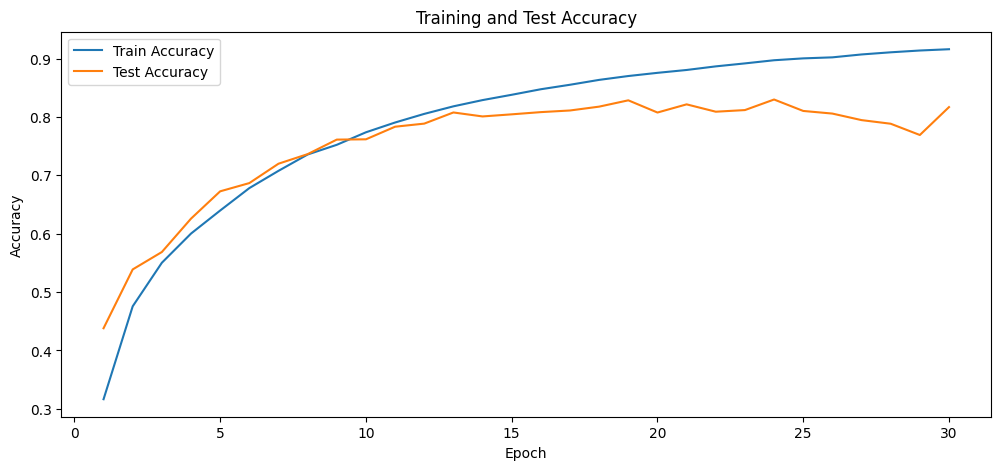

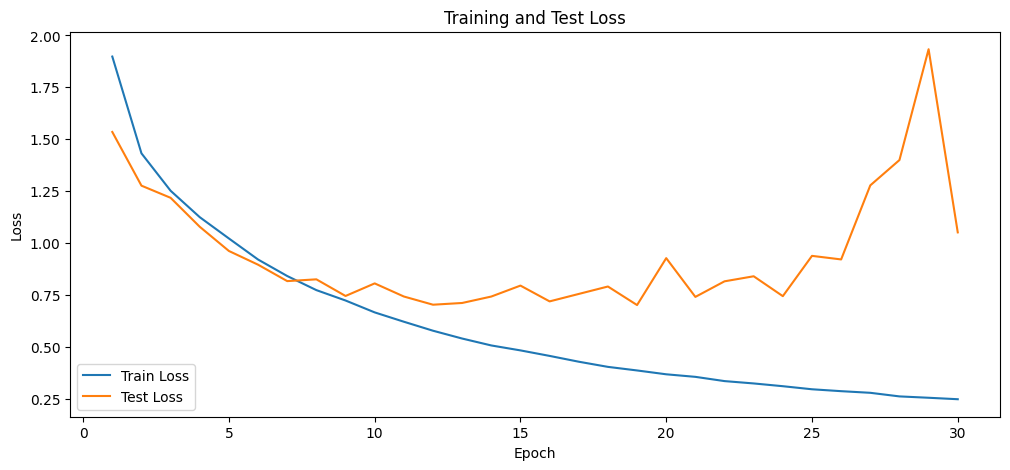

In [13]:
# Plotting Accuracy
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs+1), train_plot_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_plot_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs+1), train_plot_loss, label='Train Loss')
plt.plot(range(1, epochs+1), test_plot_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()